In [1]:
import pandas as pd

In [2]:
#Building on Cardiomegaly
finding = "Cardiomegaly"

In [3]:
#loading dataset
df = pd.read_csv("./labels.csv")

In [4]:
df

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP
...,...,...,...,...,...,...,...,...,...
1959,00000506_028.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
1960,00000506_029.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
1961,00000506_030.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
1962,00000507_000.jpg,2766,2801,No Finding,NaN,NaN,NaN,NaN,PA


In [5]:
#finding the number of positives and negatives of Cardiomegaly on the dataset

positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] != finding]
n = len(positives)
n

146

In [6]:
#Defining train and test ratios

TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [7]:
#Making the number of positives and negatives equal for better accuracy
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

## Preparing the Data

In [8]:
#making the directories
import os
rootdir = "./images/"
os.makedirs(rootdir+finding+"/test/positive")
os.makedirs(rootdir+finding+"/train/positive")
os.makedirs(rootdir+finding+"/test/negative")
os.makedirs(rootdir+finding+"/train/negative")

In [9]:
#transfer images to folders
import shutil
for idx, image in positives[:TRAIN_N].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+finding+"/train/positive/"+image["filename"]
    shutil.copy(source,dst)

In [10]:
for idx, image in positives[TRAIN_N:].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+finding+"/test/positive/"+image["filename"]
    shutil.copy(source,dst)

for idx, image in negatives[:TRAIN_N].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+finding+"/train/negative/"+image["filename"]
    shutil.copy(source,dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+finding+"/test/negative/"+image["filename"]
    shutil.copy(source,dst)

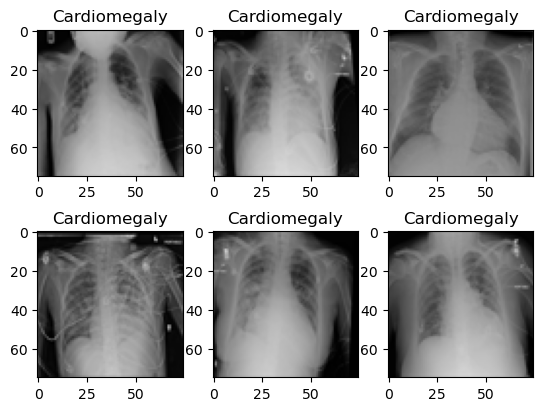

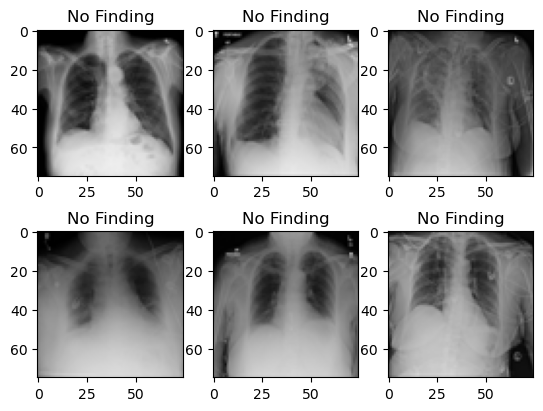

In [11]:
#Loading first six images
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 75,75

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

for idx, row in positives[:6].iterrows():
    image_path = rootdir+row["filename"]
    image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
    image_path = rootdir+row["filename"]
    image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    negative_imgs.append(load_image_into_numpy_array(image))

for idx, img in enumerate(positive_imgs[:6]):
    plt.subplot(2,3,idx+1)
    plt.title(finding)
    plt.imshow(positive_imgs[idx])
plt.show()
for idx, img in enumerate(negative_imgs[:6]):
    plt.subplot(2,3,idx+1)
    plt.title("No Finding")
    plt.imshow(negative_imgs[idx])
plt.show()

# Training

In [12]:
#Building the model

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model

pre_trained_model = InceptionV3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_ouptut = last_layer.output

x = layers.Flatten()(last_ouptut)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

In [13]:
base_dir = rootdir = "./images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [14]:
#Augmentation and Filtering 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode='binary'
)
test_generator = val_datagen.flow_from_directory(
    test_dir, 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode='binary'
)

train_step= len(os.listdir(train_pos_dir))*2
test_step = len(os.listdir(test_pos_dir))*2

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


# Run Model

In [16]:
history = model.fit(
    train_generator, 
    steps_per_epoch=train_step,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_step,
    verbose=2
)

Epoch 1/20
232/232 - 20s - loss: 2.0562 - acc: 0.4784 - val_loss: 0.6012 - val_acc: 0.6667 - 20s/epoch - 86ms/step
Epoch 2/20
232/232 - 4s - loss: 0.9191 - acc: 0.5819 - val_loss: 0.6789 - val_acc: 0.6500 - 4s/epoch - 19ms/step
Epoch 3/20
232/232 - 5s - loss: 0.7285 - acc: 0.6164 - val_loss: 0.9381 - val_acc: 0.5333 - 5s/epoch - 19ms/step
Epoch 4/20
232/232 - 4s - loss: 0.7248 - acc: 0.6207 - val_loss: 0.6766 - val_acc: 0.6167 - 4s/epoch - 19ms/step
Epoch 5/20
232/232 - 5s - loss: 0.6359 - acc: 0.6681 - val_loss: 0.6946 - val_acc: 0.6167 - 5s/epoch - 20ms/step
Epoch 6/20
232/232 - 4s - loss: 0.6743 - acc: 0.6250 - val_loss: 0.8166 - val_acc: 0.5167 - 4s/epoch - 19ms/step
Epoch 7/20
232/232 - 5s - loss: 0.6575 - acc: 0.6379 - val_loss: 0.6532 - val_acc: 0.6000 - 5s/epoch - 20ms/step
Epoch 8/20
232/232 - 5s - loss: 0.6529 - acc: 0.6595 - val_loss: 0.6378 - val_acc: 0.6167 - 5s/epoch - 20ms/step
Epoch 9/20
232/232 - 5s - loss: 0.6468 - acc: 0.6767 - val_loss: 0.6408 - val_acc: 0.6000 - 5s

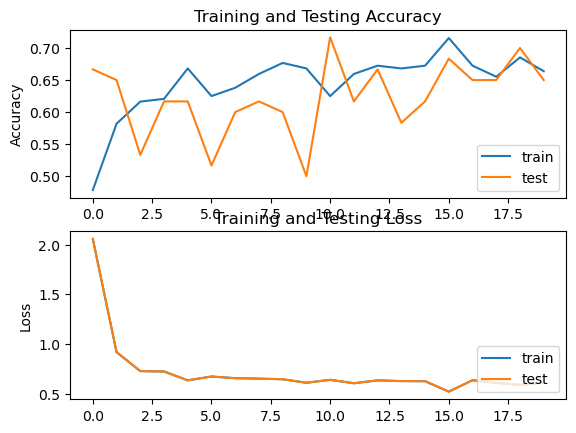

In [17]:
# plotting training and testing accuracy 
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['loss']

epoch = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epoch, acc, label ="train")
plt.plot(epoch, val_acc,label="test")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy")
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epoch, loss, label ="train")
plt.plot(epoch, val_loss,label="test")
plt.ylabel("Loss")
plt.title("Training and Testing Loss")
plt.legend(loc="lower right")

# Evaluating Performance

In [30]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
    image_path = row['filepath']
    image = Image.open(filename).resize([IMAGE_HEIGHT, IMAGE_WIDTH])
    img = load_image_into_numpy_array(image)
    exp = np.true_divide(image, 255.0)
    exp = np.stack((exp,)*3, axis=-1)
    expanded = np.expand_dims(exp, axis=0)
    pred = model.predict(expanded)[0][0]
    guess = "neg"
    if pred>0.5: guess="pos"
    title = "Image: " +row["filename"]+ "Lable: "+row["label"]+"Guess: "+guess+ "Score: " +str(pred)
    plt.title(title)
    plt.imshow(img)
    plt.show()
    return
    

In [31]:
results = []
for image in os.listdir(test_neg_dir):
    filename = test_neg_dir+"/"+image
    confidence = predict_image(filename)
    guess = "pos" if confidence>0.5 else "neg"
    results.append([filename, image, "neg",guess, confidence])

for image in os.listdir(test_pos_dir):
    filename = test_pos_dir+"/"+image
    confidence = predict_image(filename)
    guess = "pos" if confidence>0.5 else "neg"
    results.append([filename, image, "pos",guess, confidence])

sorted_results = sorted(results, key=lambda x:x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath", "filename", "label", "guess", "confidence"])

1/1 [==============================] - 0s 32ms/step


In [32]:
df.head()

,filepath,filename,label,guess,confidence
0,./images/Cardiomegaly\test\positive/00008522_0...,00008522_032.jpg,pos,pos,0.923971
1,./images/Cardiomegaly\test\positive/00013615_0...,00013615_052.jpg,pos,pos,0.912980
2,./images/Cardiomegaly\test\positive/00022706_0...,00022706_001.jpg,pos,pos,0.880570
3,./images/Cardiomegaly\test\negative/00028625_0...,00028625_000.jpg,neg,pos,0.835476
4,./images/Cardiomegaly\test\positive/00004822_0...,00004822_051.jpg,pos,pos,0.800895


1/1 [==============================] - 0s 31ms/step


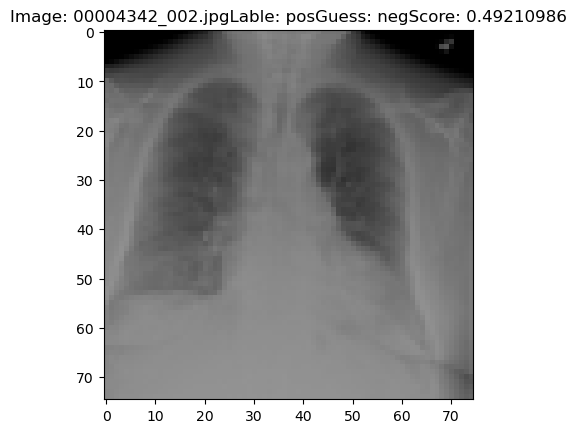

In [33]:
import random
n = random.randint(0 , len(df)-1)
show_df_row(df.iloc[n])

# Plotting and Evaluating

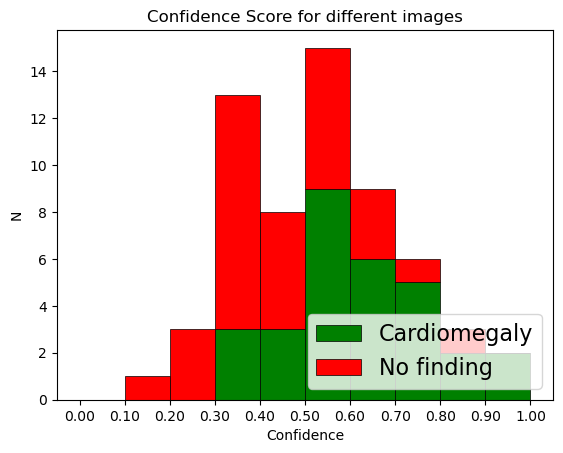

In [37]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0,1.1,0.1).tolist(),\
                            edgecolor="black", linewidth=0.5, density=False, histtype="bar", \
                            stacked=True, color=["green","red"], label=[finding, "No finding"])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title("Confidence Score for different images")
plt.legend(loc='lower right', fontsize=16)
plt.show()

In [51]:
cutoff = 0.79 @param {type:"slider", min:0, max:1, step:0.01}

SyntaxError: invalid syntax (1265231363.py, line 1)

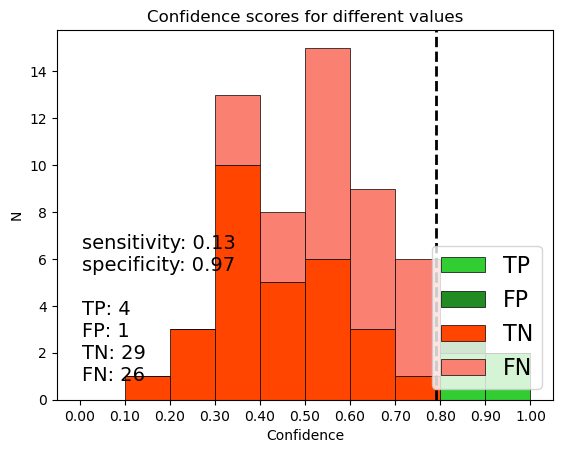

In [40]:
def create_with_cutoff(cutoff):
  __, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
  TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]
  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
           edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
           stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
           label=['TP','FP','TN','FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="lower right", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff)

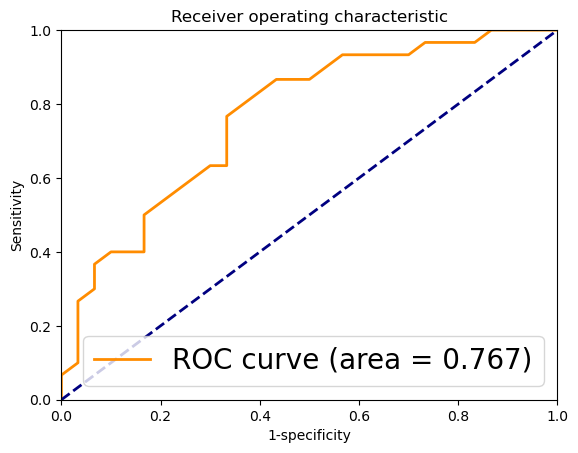

In [45]:
from sklearn.metrics import auc

def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

In [48]:
model.save('./export/'+finding)


INFO:tensorflow:Assets written to: ./export/Cardiomegaly\assets


INFO:tensorflow:Assets written to: ./export/Cardiomegaly\assets
